## File created by Reid Wyde


### Last updated 8.27.19

### TODO

add growth equations

calculate treatment values

add parameter relevance matrix/dictionary

rework algorithm so likelihood is calculated for all groups 

figure out why nuts fails to initialize

add BIC and configure pymc3 for posterior information criterion

configure theano for multiple cores // windows issue, not possible right now


#### growth equations 

exponential growth

ernesto's equations

skillman

nth root

gompertz

inverse nth root

hanfeldt

ergun

logistic growth




In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op
from scipy.integrate import odeint

plt.style.use('seaborn-darkgrid')
# This makes the plots appear inside the notebook
%matplotlib inline

np.random.seed(123)

1.16.4
1.0.4


In [3]:
#

# For each eqn
    # sample priors
    # for each group
        # params_switch(eqn, group)
        # forward(param_switch, eqn, group, priors)
        # likelihood(group, forward)
    #sum(likelihood(groups))



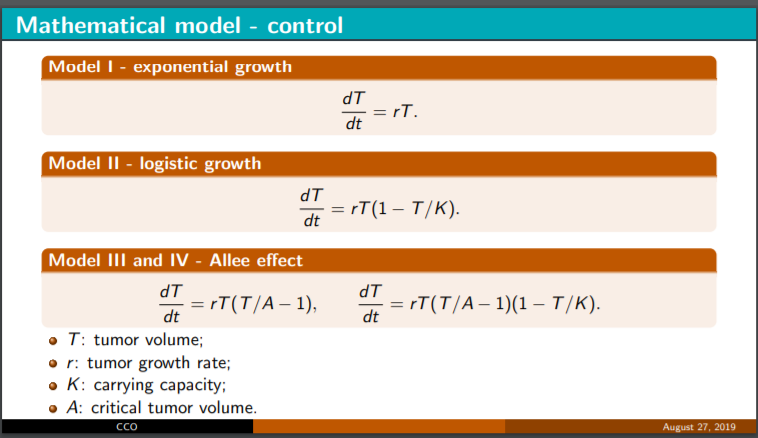

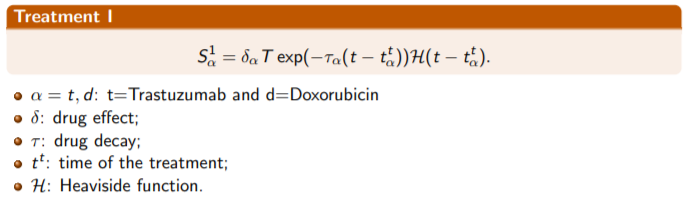

# 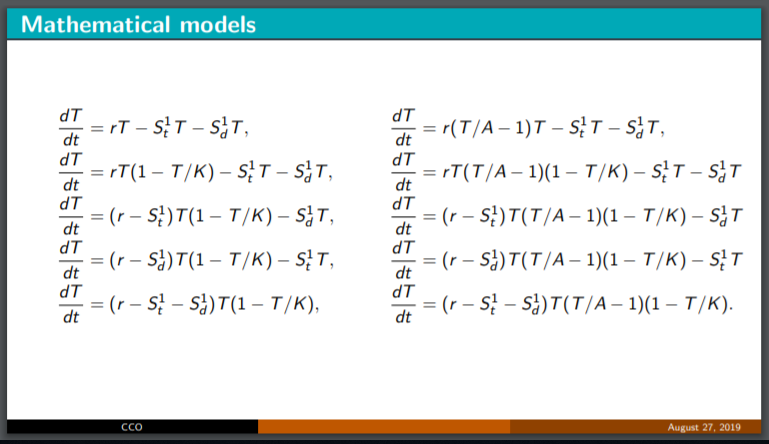

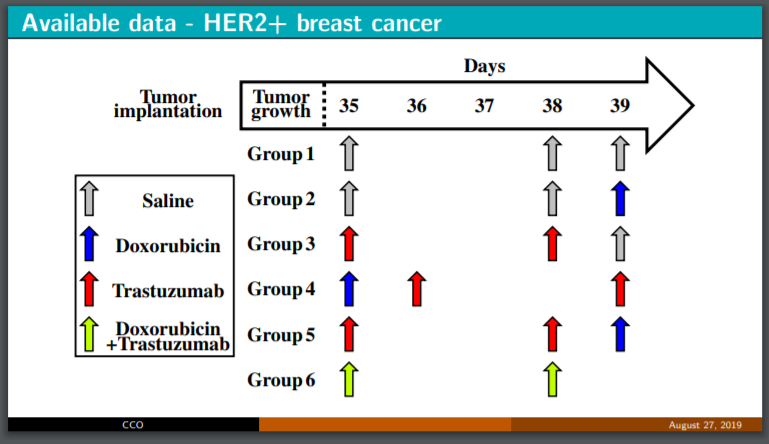

#exp
dydt = r*T - St*T - Sd*T
#allee
dydt = r*(T/A-1)*T - St*T - Sd*T
#logistic
dydt = r*T*(1-T/K) - St*T - Sd*T
#logistic and allee
dydt = r*T*(T/A-1)*(1-T/K) - St*T - Sd*T
#5
dydt = (r-St)*T*(1-T/K) - Sd*T
#6
dydt = (r-St)*T*(T/A-1)*(1-T/K) - Sd*T
#7 
dydt = (r-Sd)*T*(1-T/K) - St*T
#8 
dydt = (r-Sd)*T*(T/A - 1)*(1-T/K) - St*T
#9
dydt = (r-St-Sd)*T*(1-T/K)
#10
dydt = (r-St-Sd)*T*(T/A-1)*(1-T/K)



<div>
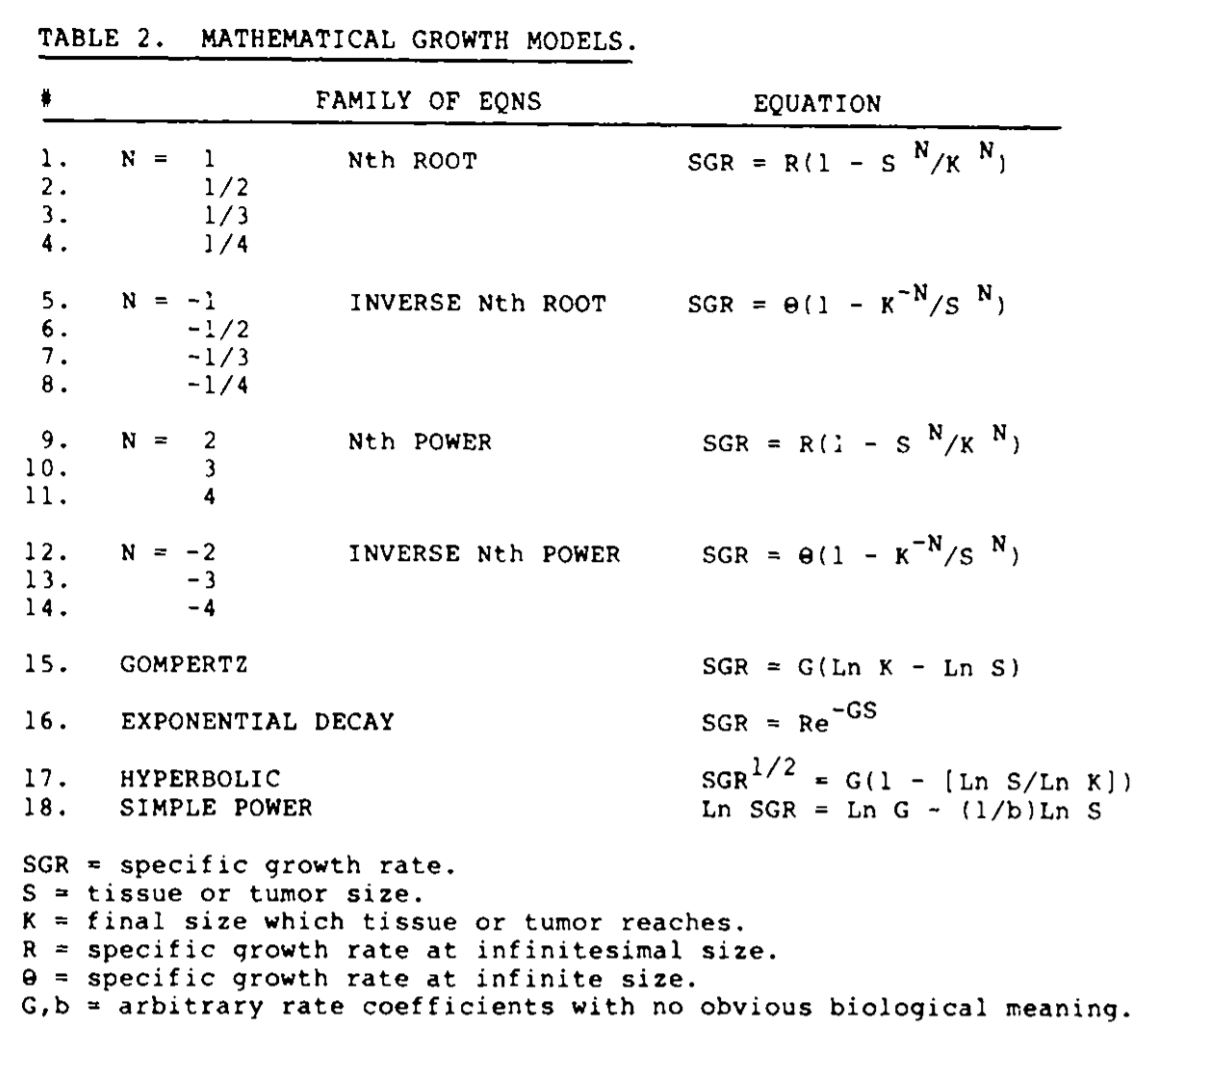
</div>

In [4]:
dirname = os.getcwd()
filename = dirname + '\..\data\\tumor_size_db.csv'
tumor_size_db = pd.read_csv(filename)
tumor_size_db.head()

,Day,G1_avg,G1_sd,G2_avg,G2_sd,G3_avg,G3_sd,G4_avg,G4_sd,G5_avg,G5_sd,G6_avg,G6_sd
0,7,53.973689,19.464756,27.939597,19.032486,44.872119,20.290405,38.955318,21.359080,30.988742,17.752230,42.366388,13.069455
1,14,56.730533,34.316923,47.079148,26.709641,59.175717,41.133786,39.697439,29.993253,34.640653,25.398323,52.488467,23.978783
2,23,90.677211,51.384002,61.140151,31.821015,112.524376,51.204812,75.404253,68.348904,61.905680,33.892752,118.747997,71.618255
3,29,182.971051,96.268908,127.343047,61.519414,211.247381,127.305794,217.351729,153.788112,134.994293,65.107710,182.961115,103.520392
4,34,284.888364,147.891820,225.843888,92.229404,346.168185,147.788359,388.344451,247.451969,257.324806,123.482982,267.228868,140.192699


In [5]:
#set of variables

#fitted
#r, double
#K, double
#A, double
#delta, double
#tau, double

#dependent variables
#St, array of doubles
#Sd, array of doubles

#constants
#ts, array of ints
#T, double
#tt_dox, tuple of ints
#tt_tras, tuple of ints


#booleans per group
#group 1
#r=1, K=1, A=1, St=0, Sd=0
#group 2
#r=1, K=1, A=1, St=0, Sd=1
#group 3
#r=1, K=1, A=1, St=1, Sd=0
#group 4
#r=1, K=1, A=1, St=1, Sd=0
#group 5
#r=1, K=1, A=1, St=1, Sd=1
#group 6
#r=1, K=1, A=1, St=1, Sd=1



In [6]:
def unit(x):
    if x>=0: return 1
    return 0

def get_tt(tuple_treatment_group):
    switcher={
        ('dox',2): [39],
        ('tras',3): [35,38],
        ('dox',4): [35],
        ('tras',4): [36,39],
        ('tras',5): [35,38],
        ('dox',5): [39],
        ('tras',6): [35,38],
        ('dox',6): [35,38]
    }  
    return switcher.get(tuple_treatment_group, [])

#S = delta*T*exp(-tau(t-tt))unit(t-tt)
def treatment(delta, Ts, tau, ts, treatment_times, ret_t=False):
    S = np.zeros(ts.shape)
    for t in ts:
        if len(treatment_times) != 0:
            T = Ts[t]
            for tt in treatment_times:
                #print(S[t])
                #print(unit(t-tt-0.0001)*delta*T*np.exp(-tau*(t-tt)))
                S[t] = S[t] + unit(t-tt-0.0001)*delta*T*np.exp(-tau*(t-tt)) #the 0.0001 reflects that treatment was given just after measuremens on treatment days
                #print('S at ' + str(t) + ' is:' + str(S[t]))
    if ret_t: return ts, S.reshape(-1,1)
    return S.reshape(-1,1)


def dox_treatment_by_group(delta, Ts, tau, ts, group):
    treatment_times = get_tt(('dox',group))
    Sd = treatment(delta, Ts, tau, ts, treatment_times)
    return Sd
    

def tras_treatment_by_group(delta, Ts, tau, ts, group):
    treatment_times = get_tt(('tras',group))
    St = treatment(delta, Ts, tau, ts, treatment_times)
    return St

def dox_treatment_all(delta, Ts_all, tau, ts):
    Sd = np.zeros((6, len(ts.ravel())))
    for group in range(6):
        Ts = Ts_all[group]
        Sd[group] = dox_treatment_by_group(delta, Ts, tau, ts, group+1).reshape(1,-1)
    return Sd   
    
def tras_treatment_all(delta, Ts_all, tau, ts):
    St = np.zeros((6, len(ts.ravel())))
    for group in range(6):
        Ts = Ts_all[group]
        St[group] = tras_treatment_by_group(delta, Ts, tau, ts, group+1).reshape(1,-1)
    return St

def treatment_inst(delta, T, tau, t, treatment_times):
    if len(treatment_times) == 0: return 0
    S = 0
    for tt in treatment_times:
        S = S + unit(t-tt-0.0001)*delta*T*np.exp(-tau*(t-tt)) #the 0.0001 reflects that treatment was given just after measuremens on treatment days
    return S

def dox_treatment_inst(delta, T, tau, t, group_idx):
    treatment_times = get_tt(('dox',group_idx+1))
    return treatment_inst(delta, T, tau, t, treatment_times)
    
def tras_treatment_inst(delta, T, tau, t, group_idx):
    treatment_times = get_tt(('tras', group_idx+1))
    return treatment_inst(delta, T, tau, t, treatment_times)
    

def dox_treatment_all_inst(delta, T_all, tau, t):
    Sd = np.zeros((6,))
    for group in range(6):
        T = T_all[group]
        Sd[group] = dox_treatment_inst(delta, T, tau, t, group)
    return Sd


def tras_treatment_all_inst(delta, T_all, tau, t):
    St = np.zeros((6,))
    for group in range(6):
        T = T_all[group]
        St[group] = tras_treatment_inst(delta, T, tau, t, group)
    return St



## Unit tests

In [7]:



def test_treatment():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    treatment_times = (10,40)
    ts, S = treatment(delta, Ts, tau, ts, treatment_times, True)
    plt.plot(ts, S)
    plt.show()
    return

def test_treatment_2():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    treatment_times = get_tt(('dox',2))
    ts, S = treatment(delta, Ts, tau, ts, treatment_times, True)
    plt.plot(ts, S)
    plt.title('G2 Dox')
    plt.show()
    return


def test_treatment_3():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    treatment_times = get_tt(('tras',3))
    ts, S = treatment(delta, Ts, tau, ts, treatment_times, True)
    plt.plot(ts, S)
    plt.title('G3 Tras')
    plt.show()
    return

def test_all_treatment():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones((6, len(ts.ravel())))
    Ts[1] = np.zeros((1, len(ts.ravel())))
    
    dox = dox_treatment_all(delta, Ts, tau, ts)
    for ii in range(len(dox)):
        row = dox[ii]
        plt.plot(ts, row)
        plt.title('Dox, Group ' + str(ii+1))
        plt.show()
        
    tras = tras_treatment_all(delta, Ts, tau, ts)
    for ii in range(len(tras)):
        row = tras[ii]
        plt.plot(ts, row)
        plt.title('Tras, Group ' + str(ii+1))
        plt.show()
        

def test_all_treatment_inst():
    delta=1
    tau=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones((6, len(ts.ravel())))
    dox = np.zeros(Ts.shape)
    tras = np.zeros(Ts.shape)
    for t in ts:
        T_all = Ts[:,t]
        dox[:,t] = dox_treatment_all_inst(delta, T_all, tau, t)
        tras[:,t] = tras_treatment_all_inst(delta, T_all, tau, t)
    
    for ii in range(len(dox)):
        plt.plot(ts, dox[ii])
        plt.title('Dox, Group ' + str(ii+1))
        plt.show()
     
    for ii in range(len(tras)):
        plt.plot(ts, tras[ii])
        plt.title('Tras, Group ' + str(ii+1))
        plt.show()
        
    

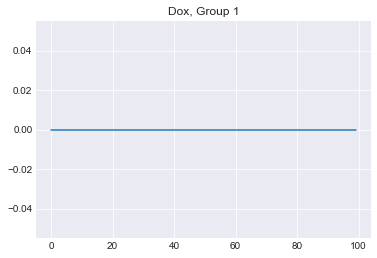

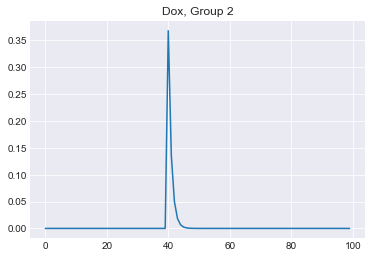

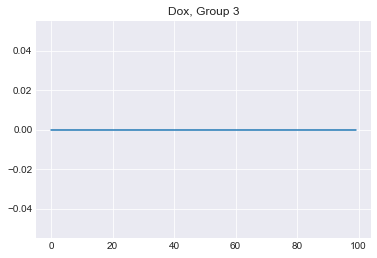

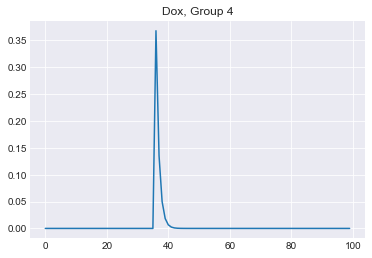

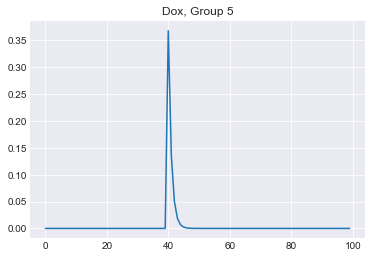

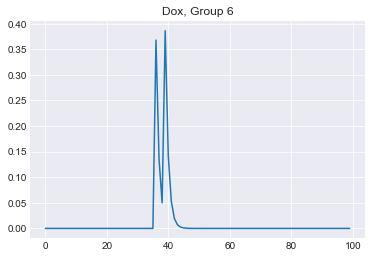

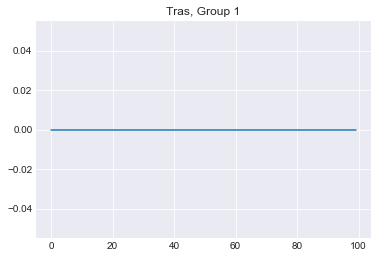

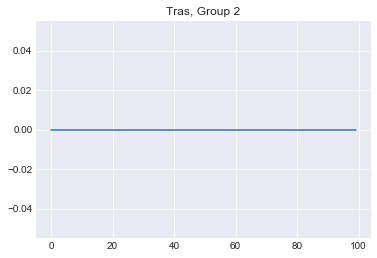

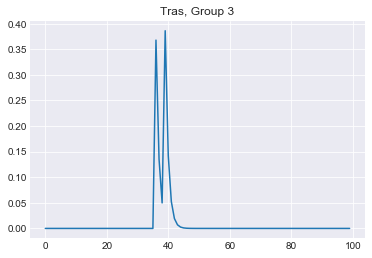

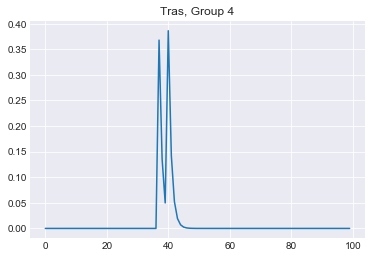

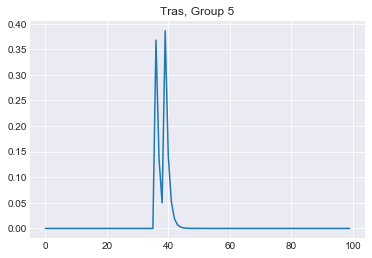

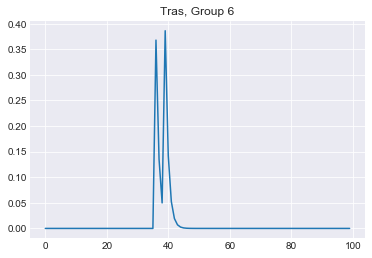

In [8]:
#test_treatment()
#test_treatment_2()
#test_treatment_3()
#test_all_treatment()
#test_all_treatment_inst()

In [9]:

def rungeKutta(ts, y0, dydt, params): 
    ret = np.zeros((6, (len(ts.ravel())))) 
    y = y0
    #print('shape of y0 in rk')
    #print(y0.shape)
    
    for i in range(1,(len(ts))) :
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dydt(t, y, params) 
        k2 = h * dydt(t, y + 0.5 * k1, params) 
        k3 = h * dydt(t, y + 0.5 * k2, params) 
        k4 = h * dydt(t, y + k3, params) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        ret[:,i] = y
        
    return ret

class growth_model(object):
    def __init__(self, times, y0):
        self._times = times
        self._y0 = y0

    def _simulate(self, params, times):
        #values = odeint(self.dydt, self._y0[0], times, (params,),rtol=1e-6,atol=1e-6)
        values = rungeKutta(times, self._y0, self.dydt, params)

        return values
    
   
    def get_param(self, param_name, n=100):
        return sum(self.trace[param_name][-n:])/n
    

In [10]:

class exp_growth_model(growth_model):
    
    def simulate(self, r, K, A, delta, tau, times=None):
        if times is None: times = self._times        
        return self._simulate([r, K, A, delta, tau], times)
    
    def dydt(self, t, y, params):
        
        if (y.shape != (6,)):
            print('y shape wrong in dydt')
            print('y is shape: ')
            print(y.shape)
            return 0

        r, K, A, delta, tau = [x for x in params]
        
        T = y                
        Sd = dox_treatment_all_inst(delta, T, tau, t)
        St = tras_treatment_all_inst(delta, T, tau, t)
        
        return r*y - Sd - St
    
    
    def backward(self, y_obs, sigmas):
        with pm.Model():
            #alpha = pm.Uniform('alpha', lower=0.04, upper=0.06) #change this to be external
            
            r = pm.Uniform('r', lower=0.02, upper= 0.04) 
            K = pm.Uniform('K', lower=1200, upper=1500)
            A = pm.Uniform('A', lower=200, upper=300)
            delta = pm.Uniform('delta', lower=1, upper=5)
            tau = pm.Uniform('tau', lower=0.5, upper=1)
            
            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, K, A, delta, tau):
                th_states = self.simulate(r, K, A, delta, tau)  # i think we could change this to pass times as well, which would avoid the need to instantiate the model with times
                #print(th_states.shape)
                return th_states
            
            forward = th_forward_model(r, K, A, delta, tau)
            
            
            y = pm.Normal('y', mu=forward, sigma = sigmas, observed=y_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 3
            startsmc=[{'r':np.random.uniform(0.02, 0.04), 
                       'K':np.random.uniform(1200, 1500), 
                       'A':np.random.uniform(200, 300),
                       'delta':np.random.uniform(1, 5),
                       'tau':np.random.uniform(0.5, 1),
                      } for _ in range(n_chains)]
            
            self.trace = pm.sample(600, tune=100, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    def get_param(self, param_name, n=100):
        return sum(self.trace[param_name][-n:])/n
    


In [11]:


ts = np.array(tumor_size_db['Day']).reshape(-1,1)
y = np.array(tumor_size_db['G1_avg']).reshape(-1,1)
ys = np.array(tumor_size_db[['G1_avg','G2_avg','G3_avg','G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas = np.array(tumor_size_db[['G1_sd','G2_sd','G3_sd','G4_sd','G5_sd','G6_sd']]).transpose()

(6, 19)
(6, 19)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [tau]
>Slice: [delta]
>Slice: [A]
>Slice: [K]
>Slice: [r]
100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [06:56<00:00,  1.70it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


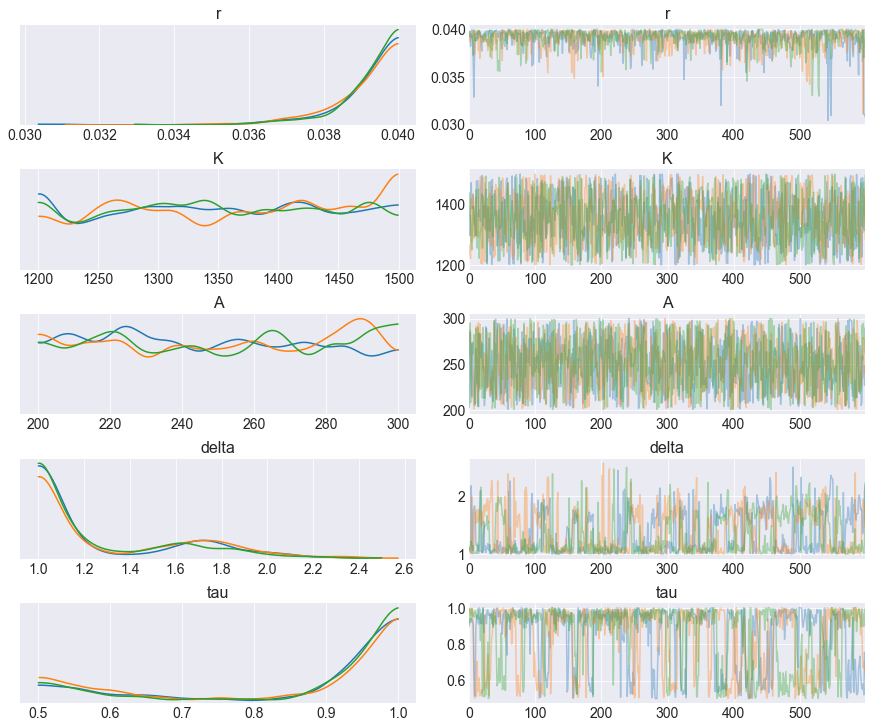

In [13]:
#unit test exp_growth_model
exp2 = exp_growth_model(ts,ys[:,0])
exp2.backward(ys,sigmas)



notes on first run
draw time 1.75 s/sample
6:40 for 700 samples
20 minutes for 3 chains
output shown below


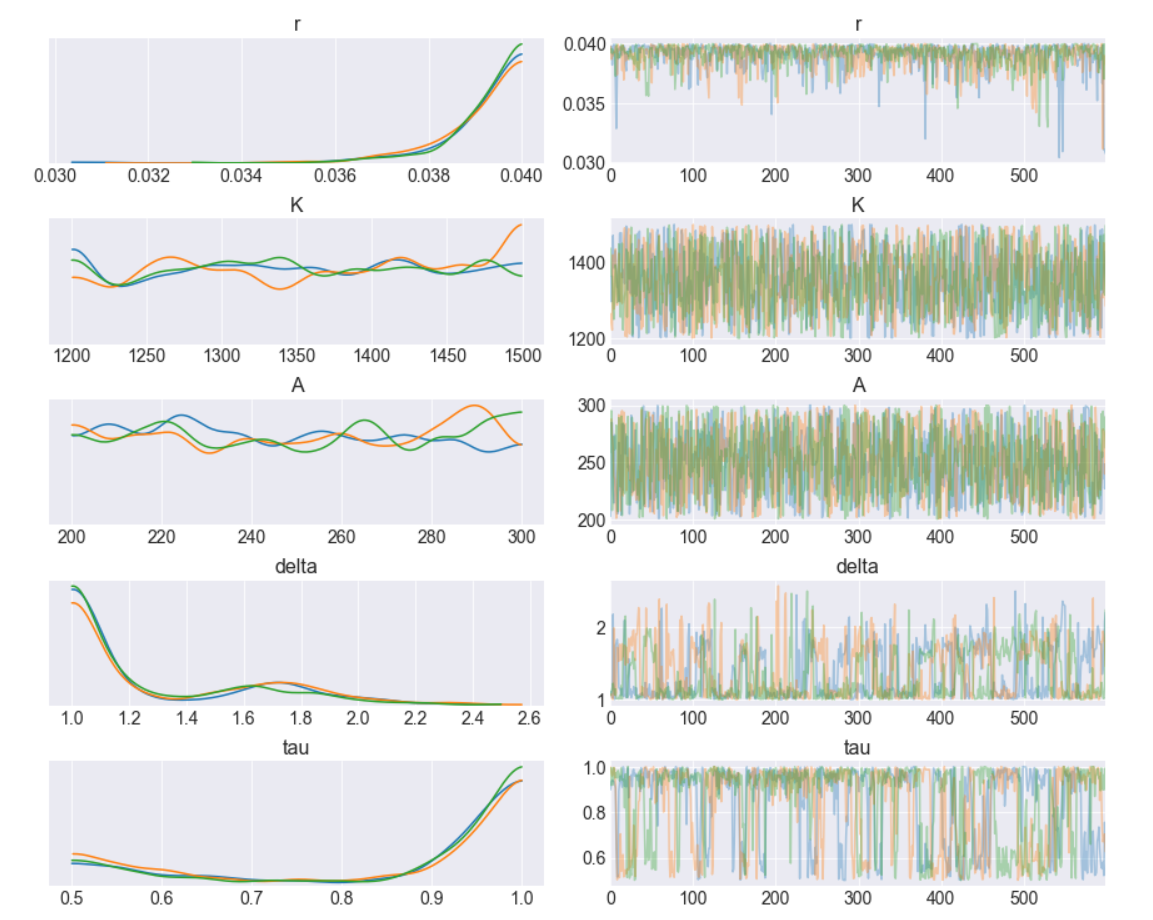

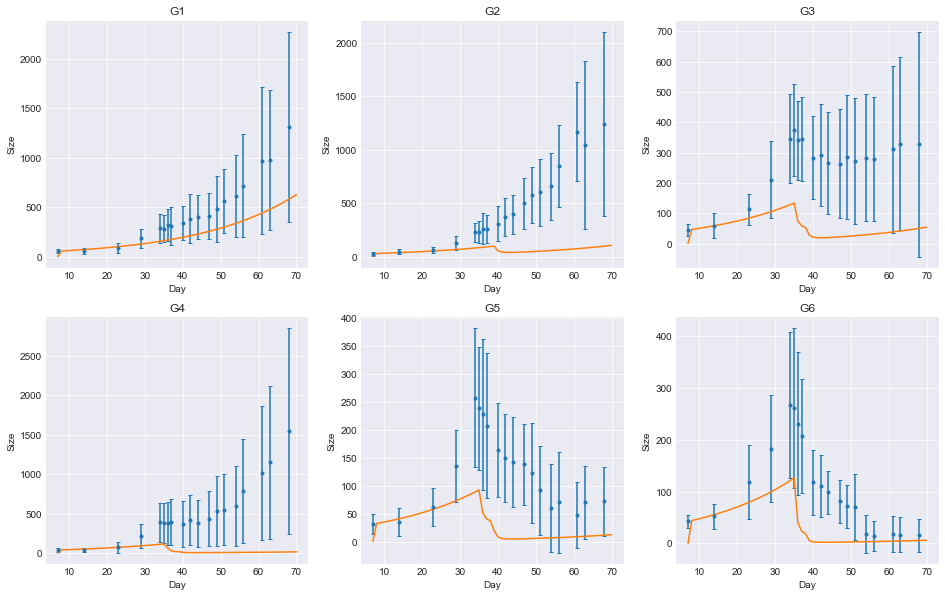

In [29]:
sim_times = np.linspace(7,70,70-7+1) #it's important that we begin the simulation at the same point that was started i.e. 7 days in was the y0
#Y_sim = exp2.simulate(exp1.get_param('alpha'),sim_times)

r = exp2.get_param('r')
K = exp2.get_param('K')
A = exp2.get_param('A')
delta = exp2.get_param('delta')
Y_sim = tau = exp2.get_param('tau')


Y_sim = exp2.simulate(r, K, A, delta, tau, sim_times)
    
    
#plot the exponential model vs the groups

plt.figure(figsize=[16,10])
for ii in range(6):
    plt.subplot(2,3,ii+1)
    #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
    plt.errorbar(tumor_size_db['Day'], ys[ii], sigmas[ii],fmt='.',capsize=2)
    plt.plot(sim_times, Y_sim[ii])
    plt.title('G' + str(ii+1))
    plt.xlabel('Day')
    plt.ylabel('Size')
plt.show()



